<a href="https://colab.research.google.com/github/rvt9bx/DS4002-Project3/blob/main/SCRIPTS/Keras_training_retry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#inmport contingencies
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import zipfile
import requests

In [ ]:
#import combined fire zip from github

# Set the URL of the ZIP file
zip_url = "https://github.com/rvt9bx/DS4002-Project3/raw/main/DATA/fire_data_combined.zip"

# Set the local path to save the downloaded ZIP file
zip_path = "/content/fire_data_combined.zip"

# Download the file from GitHub
response = requests.get(zip_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the ZIP file
extract_path = "/content/fire_data_combined"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
image_size = (250, 250)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "fire_data_combined",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1900 files belonging to 2 classes.
Using 1520 files for training.
Using 380 files for validation.


In [ ]:
#add data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

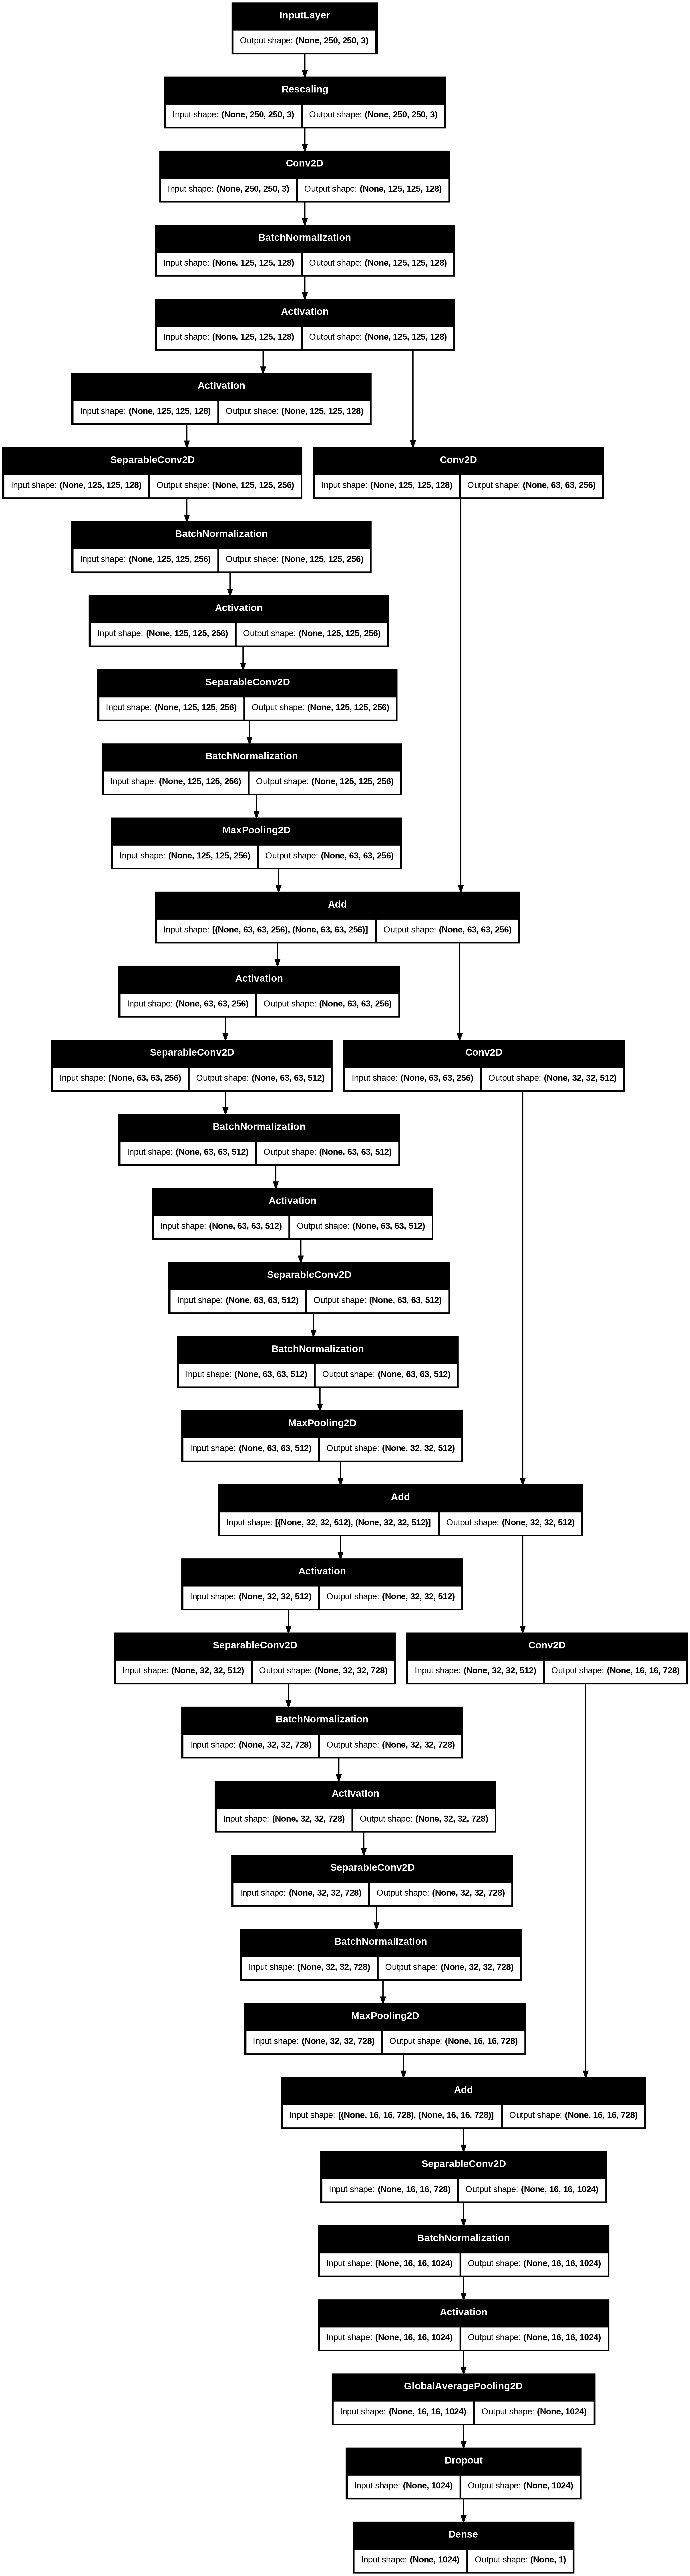

In [ ]:
#make the model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#check the model is labeling the classes correctly -- desired output = fire, nofire
class_names = train_ds.class_names
print(class_names)

['fire', 'nofire']


In [ ]:
#train the model
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss = "binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


In [ ]:
#run inference on new data
img = keras.utils.load_img("fire_data_combined/fire/fire_424.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% fire and {100 * score:.2f}% nofire.")

In [ ]:
##evaluate where the model is going wrong/getting confused with a confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = keras.ops.sigmoid(preds).numpy().flatten() > 0.5
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()
plt.show()
